In [96]:
import glob

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random

dataset_path  = config.ONEOBJ_PLAY # config.SCRIPTED_PLAY #config.RPL_PATH
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses']
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [97]:
# 
RELATIVE_JOINTS = False # use relative joiints instead of absolute angles

In [98]:
#dataset, cnt = data.create_single_dataset(dataset_path)


dataset, cnt = data.load_data(dataset_path, keys)

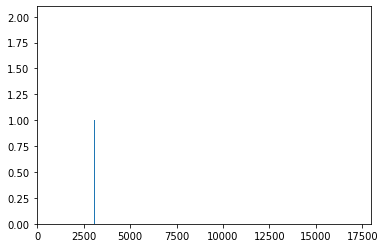

In [99]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [100]:
total_frames = sum([x[0]*x[1] for x in cnt.items()])
print(f"We have {total_frames} frames of data, which is {total_frames/20/60} minutes.")

We have 104802 frames of data, which is 87.33500000000001 minutes.


In [101]:
class PyBulletRobotSeqDataset():
    def __init__(self, dataset, batch_size=64, seq_len=42, overlap=1.0, 
                 prefetch_size=None, train_test_split=0.8, seed=42, relative_joints=False):
        self.N_TRAJS = len(dataset)

        # Split into train and validation datasets
        # List of trajectory dicts
        if train_test_split == 'last': # just use the last set of demos as validation
            self._train_data = dataset[:-1] # raw data - private
            self._valid_data = dataset[-1:]
        else:
            self._train_data = dataset[:int(self.N_TRAJS*train_test_split)] # raw data - private
            self._valid_data = dataset[int(self.N_TRAJS*train_test_split):]
        self.train_data = []
        self.valid_data = []
        self.BATCH_SIZE = batch_size
        self.PREFETCH_SIZE = prefetch_size
        self.OVERLAP = overlap
        self.relative_joints = relative_joints

        self.MAX_SEQ_LEN = seq_len ## 40 for example
        self.MIN_SEQ_LEN = seq_len//2 # so like 20
        if self.relative_joints:
            self.OBS_DIM  = dataset[0]['obs'].shape[-1] + dataset[0]['joint_poses'].shape[-1] 
        else:
            self.OBS_DIM = dataset[0]['obs'].shape[-1]
        if self.relative_joints:
            self.ACT_DIM = dataset[0]['target_poses'].shape[-1] + 1 # +1 for the gripper
        else:
            self.ACT_DIM = dataset[0]['acts'].shape[-1]
            
        self.GOAL_DIM = dataset[0]['achieved_goals'].shape[-1]

        self.random_obj = random.Random(seed)

    def create_goal(self, trajectory, ti, tf):
        return np.tile(trajectory['achieved_goals'][tf, :], (tf-ti,1))

    def traj_to_subtrajs(self, trajectory, idx):
        """
        Converts a T-length trajectory into M subtrajectories of length SEQ_LEN, pads time dim to SEQ_LEN
        """
        T = len(trajectory['obs'])
        subtrajs = []
        window_size = max(int(self.MAX_SEQ_LEN*self.OVERLAP),1)
        for ti in range(0,T,window_size):
            SEQ_LEN = np.random.randint(self.MIN_SEQ_LEN, self.MAX_SEQ_LEN) # random sequence lengths
            tf = ti + SEQ_LEN
            if T-1 < tf:
                break #trajectory would be cut off by the end of the data 
                
            pad_len = self.MAX_SEQ_LEN-(tf-ti)
            time_padding = ((0,pad_len),(0,0))
            #print(trajectory['obs'][ti:tf,:].shape, np.pad(trajectory['obs'][ti:tf,:], time_padding).shape)
            #print(np.pad(self.create_goal(trajectory, ti, tf), time_padding).shape)
            #print(np.pad(np.ones(tf-ti), time_padding[0]).shape)
            #print(np.pad(np.arange(ti, tf, 1), time_padding[0]).shape)
            
            if self.relative_joints:
                rel = trajectory['target_poses'][ti:tf] - trajectory['joint_poses'][ti:tf, :7]
                gripper = np.expand_dims(trajectory['acts'][ti:tf, -1], -1)
                action = np.pad(np.concatenate([rel, gripper], -1), time_padding)
                o = np.concatenate([trajectory['obs'][ti:tf,:],trajectory['joint_poses'][ti:tf,:]],-1).astype('float32')
            else:
                action = np.pad(trajectory['acts'][ti:tf], time_padding)
                o = trajectory['obs'][ti:tf,:]
                
            #action = np.clip(action, -0.23, 0.23) # clip to make quantisation safe
            
            subtraj_dict = {
                            'obs':np.pad(o, time_padding)
                            , 'acts':action
                            , 'goals':np.pad(self.create_goal(trajectory, ti, tf), time_padding)
                            , 'loss_mask': np.pad(np.ones(tf-ti), time_padding[0])
                            , 'dataset_path':trajectory['reset_idx'] # which trajectory it is in the datadir
                            , 'tstep_idxs':np.pad(np.arange(ti, tf, 1), time_padding[0])   # which tstep it is in the trajectory
                            }
            subtrajs.append(subtraj_dict)
        return subtrajs

    def convert_dataset(self):
        """ Converts raw dataset to a shuffled subtraj dataset """
        for idx, train_sample in enumerate(self._train_data):
            self.train_data.extend(self.traj_to_subtrajs(train_sample, idx))

        for idx, valid_sample in enumerate(self._valid_data):
            self.valid_data.extend(self.traj_to_subtrajs(valid_sample, idx))

    def create_tf_ds(self, ds_type='train'):
        dataset = self.train_data if ds_type=='train' else self.valid_data
        def gen():
            for d in dataset:
                yield (d['obs'], d['acts'], d['goals'], d['loss_mask'], d['dataset_path'], d['tstep_idxs'])

        with tf.device('/cpu:0'):
            tf_ds =  tf.data.Dataset.from_generator(
                        gen
                        , output_types = (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32)
                        , output_shapes = ((None,self.OBS_DIM), (None,self.ACT_DIM), (None,self.GOAL_DIM), (None), (None), (None)
            ))
            tf_ds = tf_ds.shuffle(len(dataset))
            tf_ds = tf_ds.batch(self.BATCH_SIZE, drop_remainder=True)
            tf_ds = tf_ds.prefetch(self.PREFETCH_SIZE)
        return tf_ds

In [102]:
rsd = PyBulletRobotSeqDataset(dataset, batch_size=32, overlap=0.01, train_test_split='last', relative_joints=RELATIVE_JOINTS)

In [103]:
rsd.convert_dataset()

In [104]:
tf_train_data, tf_valid_data = rsd.create_tf_ds('train'), rsd.create_tf_ds('valid')

In [105]:
tf_train_data

<PrefetchDataset shapes: ((32, None, 19), (32, None, 8), (32, None, 11), <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32)>

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [12]:
def create_actor(layer_size=1024, training=True, latent_dim = 128, GCBC=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, rsd.OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, rsd.GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:
      x = Concatenate()([o,g])
    else:
      x =  Concatenate()([o,z,g])

    x = Masking(mask_value=0.)(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_1')(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_2')(x)
    acts = Dense(rsd.ACT_DIM-1, activation=None, name='acts')(x)
    gripper = Dense(1, activation='sigmoid', name='gripper')(x)*0.04

    actions = Concatenate()([acts, gripper])

    if GCBC:
      return Model([o, g], actions)
    else:
      return Model([o, z, g], actions)

In [13]:
from tensorflow.keras.layers import Bidirectional

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist


class ENCODER_LSTM(Model):
  def __init__(self, layer_size=1024, latent_dim=256, p_dropout=0.3):
    super(ENCODER_LSTM, self).__init__()

    self.bi_lstm = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode='concat')
    self.bi_lstm2 = Bidirectional(LSTM(layer_size, return_sequences=True, return_state=False), merge_mode=None)
    self.mu = Dense(latent_dim)
    self.scale = Dense(latent_dim, activation='softplus')
    self.dropout1 = tf.keras.layers.Dropout(p_dropout)
    self.dropout2 = tf.keras.layers.Dropout(p_dropout)

  def call(self, obs, acts, training = False):
    x = tf.concat([obs,acts], axis = 2) # concat observations and actions together.
    x = self.bi_lstm(x)
    x = self.dropout1(x, training=training)
    x = self.bi_lstm2(x)
    bottom = x[0][:,-1, :] # Take the last element of the bottom row
    top = x[1][:,0,:] # Take the first elemetn of the top row cause Bidirectional, top row goes backward.
    x = tf.concat([bottom, top], axis = 1)
    x = self.dropout2(x, training=training)
    mu = self.mu(x)
    s = self.scale(x)
    dist = tfd.Normal(loc=mu, scale=s)
    return dist


def create_planner(layer_size=2048, training=True, epsilon=1e-4, latent_dim = 256):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(rsd.OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(rsd.GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate()([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    x = Dense(layer_size, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)

    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], [mixture,mu])

# Load our beautiful models

In [14]:
# Maybe load model 
v_it = iter(tf_valid_data.repeat(-1))

states, acts, goals, valid_mask,pth,tsteps = v_it.next()

In [15]:
def create_actor(layer_size=1024, training=True, latent_dim = 128, GCBC=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, rsd.OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, rsd.GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:
        x = Concatenate()([o,g])
    else:
        x =  Concatenate(name='inputconcat')([o,z,g])

    #x = Masking(mask_value=0.)(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_1')(x)
    x = LSTM(layer_size, return_sequences=True, return_state=False, stateful=stateful, name='LSTM_in_2')(x)
    acts = Dense(rsd.ACT_DIM-1, activation=None, name='acts')(x)
    gripper = Dense(1, activation='sigmoid', name='gripper')(x)*0.04

    actions = Concatenate(name='actconcat')([acts, gripper])

    if GCBC:
        return Model([o, g], actions)
    else:
        return Model([o, z, g], actions)
    


In [16]:
LAYER_SIZE = 1024
LATENT_DIM = LAYER_SIZE//8

# model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':True}
# model = create_actor(**model_params)

model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
model = create_actor(**model_params)

model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
encoder = ENCODER_LSTM(latent_dim=LATENT_DIM)
planner = create_planner(**model_params)

In [17]:
encoding = encoder(states,acts)
plan, _ = planner((states[:, 0, :], goals[:, 0, :]))
# true validation performance, w/ planner
z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
#model.reset_states()
pred_acts = model((states, z, goals)) # TODO Check can you backprop through samples

In [18]:
path = 'cyclichuber'
model.load_weights(f'saved_models/{path}/model.h5')
encoder.load_weights(f'saved_models/{path}/encoder.h5')
planner.load_weights(f'saved_models/{path}/planner.h5')

ValueError: Shapes (158, 4096) and (166, 4096) are incompatible

In [12]:
#@title Sample a batch for timeseries plotting
# Lets plot pred actions vs true actions
v_it = iter(tf_valid_data.repeat(-1))

states, acts, goals, masks,_,_ = v_it.next()

In [21]:
#@title Sample a batch for timeseries plotting

encoding = encoder(states,acts)
plan, _ = planner((states[:, 0, :], goals[:, 0, :])) # TODO this is really aggravating, if we have variable sequence lengths we need to pass
                                                      # Through the indices of the final index, can't just use the last 1, unless we copy it out instead of tiling?
# check if encoder is overfitting on validation
z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
enc_act_distrib = model((states, z_enc, goals))

# true validation performance, w/ planner
z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, rsd.MAX_SEQ_LEN, 1))
pred_acts = model((states, z, goals)) # TODO Check can you backprop through samples

In [15]:
seq_lens = []
for idx in range(0,len(masks)):
    seq_lens.append(len(np.where(masks[idx] == 1)[0])-1)

In [23]:
import pybullet as p

def create_rpy(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    rpys = []
    for i in range(len(a)):
        rpys.append(p.getEulerFromQuaternion(a[i,3:7]))
    xyz = a[:,0:3]
    rpy = np.array(rpys)
    g = np.expand_dims(a[:,-1],1)
    
    return np.concatenate([xyz, rpy, g], -1)

In [16]:


def quat_sign_flip(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    angles = [a[0,3:7]]
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = angles[-1] 
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
            angles.append(-quat)
        else:
            angles.append(quat)
        #print(np.sign(quat), np.sign(last_quat), (np.sign(quat)== -np.sign(last_quat)).all())
    
    #print(xyz.shape, q.shape, g.shape,q)
    return np.concatenate([xyz, q, g], -1)


array([[-0.20800054,  0.26483172,  0.00793105,  0.58324593, -0.5495927 ,
        -0.3886455 , -0.45467216,  0.        ],
       [-0.20375818,  0.25486535,  0.01416814,  0.59325355, -0.5342797 ,
        -0.39608362, -0.45355618,  0.        ],
       [-0.19994408,  0.24395593,  0.02201295,  0.59274733, -0.52189493,
        -0.40672418, -0.45918593,  0.        ],
       [-0.19504854,  0.22433348,  0.03253657,  0.589086  , -0.5237    ,
        -0.415589  , -0.45387414,  0.        ],
       [-0.18752238,  0.20523055,  0.04086286,  0.58579034, -0.52748793,
        -0.42074338, -0.44897792,  0.        ],
       [-0.17665648,  0.18650033,  0.04849142,  0.5878635 , -0.5243441 ,
        -0.42175928, -0.4489976 ,  0.        ],
       [-0.16196759,  0.15892829,  0.05519885,  0.60194445, -0.5175008 ,
        -0.42082655, -0.43904534,  0.        ],
       [-0.15392308,  0.13918085,  0.05679655,  0.6055844 , -0.520809  ,
        -0.42250192, -0.42838964,  0.        ],
       [-0.14272816,  0.11477466

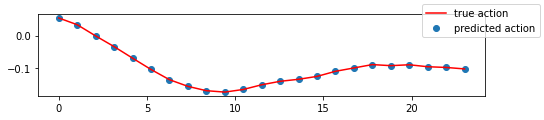

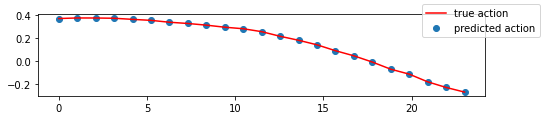

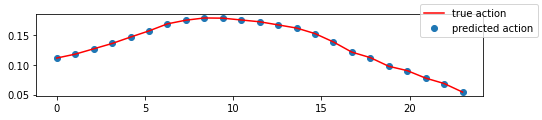

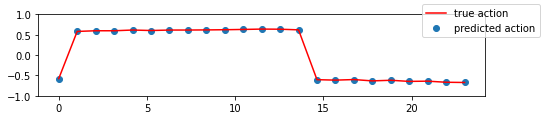

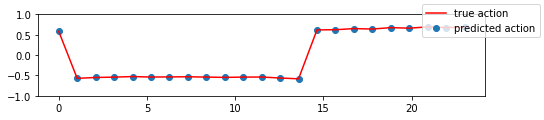

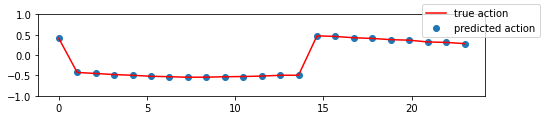

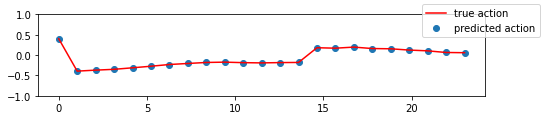

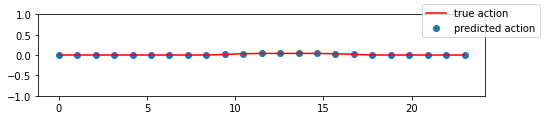

In [17]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 15

length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    if i >= 3and i < 8:
        axes[0,0].set_ylim([-1,1])
    true = axes[0,0].plot(x,acts[idx, :int(seq_lens[idx]),i],'r')
    #predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    #enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')
    true = axes[0,0].scatter(x,acts[idx, :int(seq_lens[idx]),i])
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

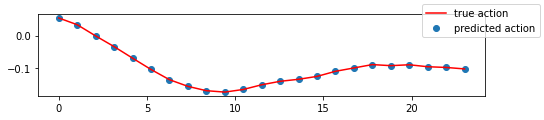

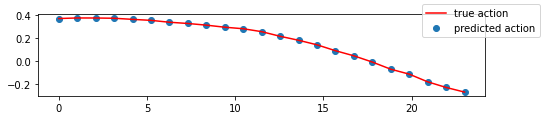

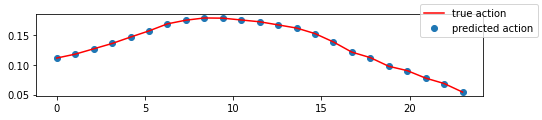

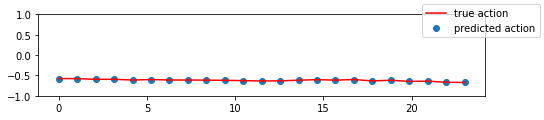

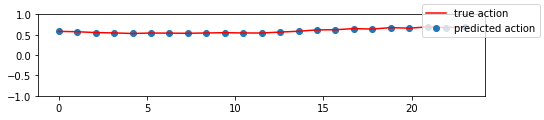

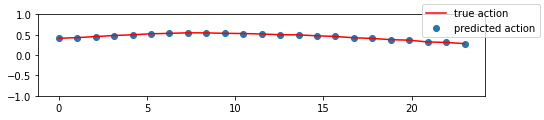

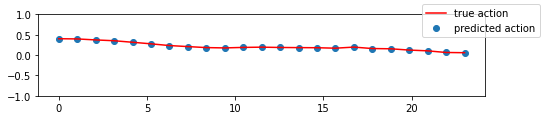

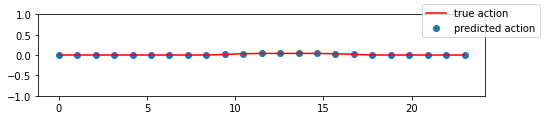

In [19]:

#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 15

length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,8):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    if i >= 3and i < 8:
        axes[0,0].set_ylim([-1,1])
    true = axes[0,0].plot(x,quat_sign_flip(acts,idx)[:,i],'r')
    #predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    #enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')
    true = axes[0,0].scatter(x,quat_sign_flip(acts,idx)[:,i])
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

In [3]:
import gym
import time
import pandaRL
if RELATIVE_JOINTS:
    env = gym.make('pandaPlayJoints1Obj-v0')
    #env = gym.make('pandaPlayJoints-v0')
else:
    env = gym.make('pandaPlay1Obj-v0')
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


{'observation': array([-1.1993246e-01,  2.5839269e-01,  5.1459614e-02, -4.9999902e-01,
         4.9999261e-01,  5.0000644e-01,  5.0000197e-01,  0.0000000e+00,
        -1.4336162e-02,  4.7583759e-02, -2.2230021e-04,  4.5622150e-14,
        -8.1749149e-15,  1.7225352e-14,  1.0000000e+00,  8.0247079e-35,
         0.0000000e+00,  4.3836804e-03,  0.0000000e+00], dtype=float32),
 'achieved_goal': array([-1.4336162e-02,  4.7583759e-02, -2.2230021e-04,  4.5622150e-14,
        -8.1749149e-15,  1.7225352e-14,  1.0000000e+00,  8.0247079e-35,
         0.0000000e+00,  4.3836804e-03,  0.0000000e+00], dtype=float32),
 'desired_goal': array([0.07235649, 0.28273353, 0.07042582], dtype=float32),
 'controllable_achieved_goal': array([-0.11993246,  0.2583927 ,  0.05145961,  0.        ], dtype=float32),
 'full_positional_state': array([-1.1993246e-01,  2.5839269e-01,  5.1459614e-02, -4.9999902e-01,
         4.9999261e-01,  5.0000644e-01,  5.0000197e-01,  0.0000000e+00,
        -1.4336162e-02,  4.7583759e-0

In [25]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False}
model = create_actor(**model_params)
model.load_weights(f'saved_models/{path}/model.h5')

In [106]:

def quat_sign_flip(a):
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = a[i-1,3:7]
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
             a[i,3:7] = - a[i,3:7]
    return a 


In [107]:
import time

def test_subsequences(data, idx, retries = 3, replay=False, replan_interval=20):
    
    
    obs, acts, goals, masks, pth, tsteps = data
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    
    env.p.restoreState(fileName=dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    print(dataset_path+'states_and_ims/'+str(int(pth[idx]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    o = tf.expand_dims(tf.expand_dims(obs[idx][0],0),0)
    
    goal = goals[idx, traj_end,:]
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    
    
    if replay:
        retries = 1

    a_true =  quat_sign_flip(acts[idx, :traj_end].numpy())
    a_pred = []
    
    for j in range(0,retries):
        if not replay:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
            model.reset_states()
            replan_horizon = 30
        else:
            replan_horizon = traj_end
            print(replan_horizon)
        for i in range(0, replan_horizon):

            if replay:
                a=a_true[i, :] # uncomment this to replay play subsequences
            else:
                a = model((o, z,goal)).numpy().squeeze()
                a_pred.append(model((o, z,goal)).numpy().squeeze())
            
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints']]), 0),0)
    return np.array(a_true), np.array(a_pred)

In [108]:
v_it = iter(tf_valid_data.repeat(-1))

In [115]:
for i in range(0,1):
    data = v_it.next()
    idx = np.random.choice(len(data[0]))
    true, pred = test_subsequences(data, idx, retries = 2, replay=True)

data_collection/collected_data/play_one_obj_demos/states_and_ims/2/env_states/1621.bullet
38


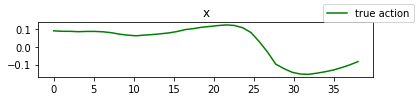

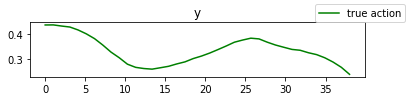

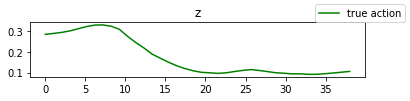

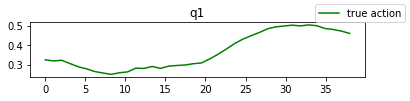

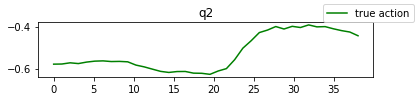

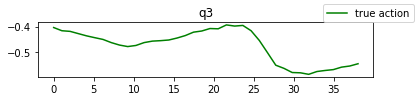

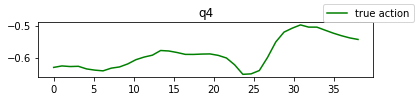

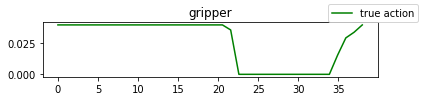

In [116]:
length_true = len(true)
length_pred = len(pred)
actions_space = true.shape[-1]
x_true = np.linspace(0, length_true, num=length_true) 
x_pred = np.linspace(0, length_pred, num=length_pred) 
labels = ['x','y','z','q1','q2','q3','q4','gripper']
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(6,1.0), squeeze=False)
    # One Model
    axes[0,0].plot(x_true,true[:,i],'green')
    #axes[0,0].plot(x_pred,pred[:,i], 'b')
    fig.legend( ('true action', 'predicted action'))
   
    plt.title(labels[i])
    plt.show()

In [40]:
import tests
from importlib import reload
reload(tests)

for test in tests.test_list:
    # get the goal and reset to the init position
    print(f"\n Test: {test.__name__}")
    goal = tf.expand_dims(tf.expand_dims(test(env),0),0)
    state = env.panda.calc_state()
    o = tf.expand_dims(tf.expand_dims(np.concatenate([state['observation'], state['joints']]),0),0)
    initial_ag = state['achieved_goal']

    retries = 2
    for i in range(0,retries):
        plan, _ = planner((o[0], goal[0]))
        z = tf.expand_dims(plan.sample(),0)
        model.reset_states()
        for i in range(0, 40):
            a = model((o, z,goal)).numpy().squeeze()
            time.sleep(0.02)
            o, r, d, _ = env.step(a)
            o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints']]), 0),0)
            
    state = env.panda.calc_state()
    final_ag = state['achieved_goal']
    
    tests.measure_progress(initial_ag, final_ag, np.squeeze(goal.numpy()))
            
    


 Test: door_left
0/1 [........................................] - ETA: 0s - L1: 0.0369
 Test: door_right
0/1 [==================>...........] - ETA: 0s - L1: 0.0094
 Test: open_drawer
0/1 [===========>..................] - ETA: 0s - L1: 0.0106
 Test: close_drawer
-4/1 [...................................................................................................................................................................................] - ETA: 0s - L1: 0.1089
 Test: push_left
-1/1 [.......................................................................] - ETA: 0s - L1: 0.0435
 Test: push_right
-4/1 [............................................................................................................................................................................] - ETA: 0s - L1: 0.1044
 Test: block_in_cupboard_right
0/1 [====================>.........] - ETA: 0s - L1: 0.0118
 Test: block_in_cupboard_left
0/1 [====>.........................] - ETA: 0s - L1: 0.0338
 Tes